<a href="https://colab.research.google.com/github/anshudaur/TensorFlowProjects/blob/master/CVDL_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.0.0


In [0]:
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
# data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
#                                          fname='flower_photos', untar=True)
# # print(data_dir)
# data_dir = pathlib.Path(data_dir)
# print(data_dir)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/CVDL_Project/dataset/'  #change dir to your project folder

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [7]:
data_dir=pathlib.Path(root_path+'train')
valid_dir=pathlib.Path(root_path+'valid')
test_dir=pathlib.Path(root_path+'test')
print(data_dir,',',valid_dir,',',test_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

gdrive/My Drive/CVDL_Project/dataset/train , gdrive/My Drive/CVDL_Project/dataset/valid , gdrive/My Drive/CVDL_Project/dataset/test


4918

In [5]:
import numpy as np
BATCH_SIZE = 64
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
print(CLASS_NAMES)

['98' '99' '93' '97' '96' '94' '90' '95' '92' '91' '9' '89' '85' '82' '83'
 '84' '88' '86' '87' '81' '8' '80' '79' '78' '71' '72' '75' '74' '76' '73'
 '70' '77' '69' '7' '67' '68' '62' '61' '64' '63' '65' '60' '66' '6' '59'
 '58' '57' '56' '51' '49' '53' '54' '55' '52' '5' '50' '47' '48' '45' '40'
 '44' '41' '4' '43' '42' '46' '39' '38' '37' '36' '34' '31' '3' '35' '29'
 '32' '30' '33' '28' '27' '26' '25' '22' '18' '23' '21' '20' '24' '2' '19'
 '16' '17' '14' '15' '12' '11' '100' '102' '101' '1' '13' '10']


In [10]:
 image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
 train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                      batch_size=BATCH_SIZE,
                                                      shuffle=True,
                                                      target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                      classes = list(CLASS_NAMES),class_mode='categorical')
valid_data_gen = image_generator.flow_from_directory(directory=str(valid_dir),
                                                      batch_size=BATCH_SIZE,
                                                      shuffle=True,
                                                      target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                      classes = list(CLASS_NAMES),class_mode='categorical')
test_data_gen = image_generator.flow_from_directory(directory=str(test_dir),
                                                      batch_size=BATCH_SIZE,
                                                      shuffle=True,
                                                      target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                      classes = list(CLASS_NAMES),class_mode='categorical')

Found 4918 images belonging to 102 classes.
Found 1638 images belonging to 102 classes.
Found 1638 images belonging to 102 classes.


In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [0]:
# image_batch, label_batch = next(train_data_gen)
# show_batch(image_batch, label_batch)

In [0]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [0]:
import numpy as np

def one_hot_encode(x, n_classes):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
     """
    return np.eye(n_classes)[x]
       
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  #return parts[-2] == CLASS_NAMES
  #one_hot_list = one_hot_encode(parts[-2], 102)
  return tf.one_hot([parts[-2]],depth=102)


In [0]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [0]:
def process_path(file_path):
  label = get_label(file_path)
  print(label)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [47]:
import os
AUTOTUNE = tf.data.experimental.AUTOTUNE
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
print(labeled_ds)

Tensor("one_hot:0", shape=(1, 102), dtype=float32)
<DatasetV1Adapter shapes: ((224, 224, 3), (1, 102)), types: (tf.float32, tf.float32)>


In [51]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label)

UnimplementedError: ignored

In [0]:


def prepare_for_training(ds, cache=True, shuffle_buffer_size=6000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [0]:
#function to check the performance of Oxford Flower 102 dataset:
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))

timeit(train_data_gen)

....................................

In [0]:
# image_batch, label_batch = next(iter(labeled_ds))
# data = tf.data.Dataset.from_tensor_slices(
#     (image_batch.reshape(image_batch.shape[0],224,224,3).astype(np.float32) / 255, label_batch.astype(np.int32)))
# data = data.shuffle(buffer_size=60000).batch(128).repeat()

train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

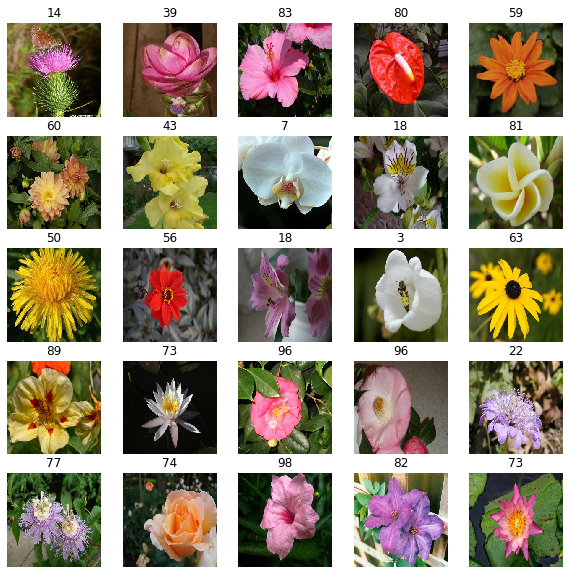

In [0]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [0]:
from tensorflow.keras import datasets, layers, models
'''layer_list = [layers.Conv2D(128, (3, 3), activation='relu', input_shape=(224, 224, 3)),
              layers.Conv2D(128, (3, 3), activation='relu'),
              layers.Conv2D(256, (3, 3), activation='relu'),
              layers.Conv2D(256, (3, 3), activation='relu'),
              layers.Flatten(),layers.Dense(102)]'''

layer_list = [layers.Conv2D(32, (4, 4), activation='relu', input_shape=(224, 224, 3)),
              layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
              layers.Conv2D(64, (4, 4), activation='relu'),
              layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
              layers.Conv2D(128, (4, 4), activation='relu'),
              layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
              layers.Conv2D(256, (4, 4), activation='relu'),
              layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
              layers.Conv2D(128, (4, 4), activation='relu'),
              layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
              layers.Flatten(),layers.Dense(102,activation='softmax'),layers.Dense(102)]

model = tf.keras.Sequential(layer_list)

#learning_rate=1e-4

opt = tf.keras.optimizers.Adam()
# from_logits = True!! #neverforget
loss_fn = tf.keras.losses.CategoricalCrossentropy()
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
train_entropy_metric = tf.keras.metrics.CategoricalCrossentropy()


In [0]:
model.compile(optimizer=opt, loss=loss_fn, metrics=['acc',train_entropy_metric])

In [19]:
#model.fit(image_batch, steps_per_epoch=STEPS_PER_EPOCH, epochs=2)
import time
start = time.time()
model.fit_generator(train_data_gen,
                    epochs=10,
                    validation_data=valid_data_gen)
end = time.time()
print('Processing time:',(end - start)/60)
model.save_weights(root_path+'cnn_model.h5')

Epoch 1/10
77/77 [==============================] - 1635s 21s/step - loss: 7.8482 - acc: 0.0128 - categorical_crossentropy: 7.8490 - val_loss: 8.6061 - val_acc: 0.0134 - val_categorical_crossentropy: 8.6479
Epoch 2/10
77/77 [==============================] - 57s 737ms/step - loss: 8.0020 - acc: 0.0132 - categorical_crossentropy: 7.9989 - val_loss: 8.6311 - val_acc: 0.0134 - val_categorical_crossentropy: 8.6199
Epoch 3/10
77/77 [==============================] - 57s 737ms/step - loss: 8.1106 - acc: 0.0132 - categorical_crossentropy: 8.1131 - val_loss: 7.4779 - val_acc: 0.0134 - val_categorical_crossentropy: 7.5087
Epoch 4/10
77/77 [==============================] - 57s 739ms/step - loss: 8.2063 - acc: 0.0132 - categorical_crossentropy: 8.2078 - val_loss: 7.4870 - val_acc: 0.0134 - val_categorical_crossentropy: 7.4982
Epoch 5/10
77/77 [==============================] - 57s 745ms/step - loss: 8.2615 - acc: 0.0132 - categorical_crossentropy: 8.2655 - val_loss: 8.6178 - val_acc: 0.0134 - va